In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm 
import warnings
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 6) # Размер графиков по умолчанию

"""
Мы решаем линейное уравнение переноса (адвекции):
$$ \frac{\partial u}{\partial t} + c(x, t) \frac{\partial u}{\partial x} = f(x, t) $$
в области $x \in [x_{min}, x_{max}]$ и по времени $t \in [0, t_{max}]$.

Где:
- $u(x, t)$ - переносимая величина (например, концентрация, температура).
- $c(x, t)$ - скорость переноса.
- $f(x, t)$ - член, описывающий источники/стоки.

Нам необходимы начальные и граничные условия:
- **Начальное условие (НУ):** $u(x, 0) = u_{initial}(x)$
- **Левое граничное условие (ЛГУ):** $u(x_{min}, t) = u_{left\_bc}(t)$
- **Правое граничное условие (ПГУ):** $u(x_{max}, t) = u_{right\_bc}(t)$

---
### Параметры конкретной задачи в этом ноутбуке:
- **Область:** $x \in [0, 1]$, $t \in [0, 1]$
- **Скорость:** $c(x, t) = c = 0.5$ (постоянная, положительная -> перенос вправо)
- **Источниковый член:** $f(x, t) = 0$ (однородное уравнение)
- **Начальное условие:** $u(x, 0) = \sin^3(\pi x)$ (волновой профиль)
- **Граничные условия:**
    - ЛГУ: $u(0, t) = 0$
    - ПГУ: $u(1, t)$ берется из аналитического решения, чтобы избежать влияния отражений от границы на анализ самих схем.

"""

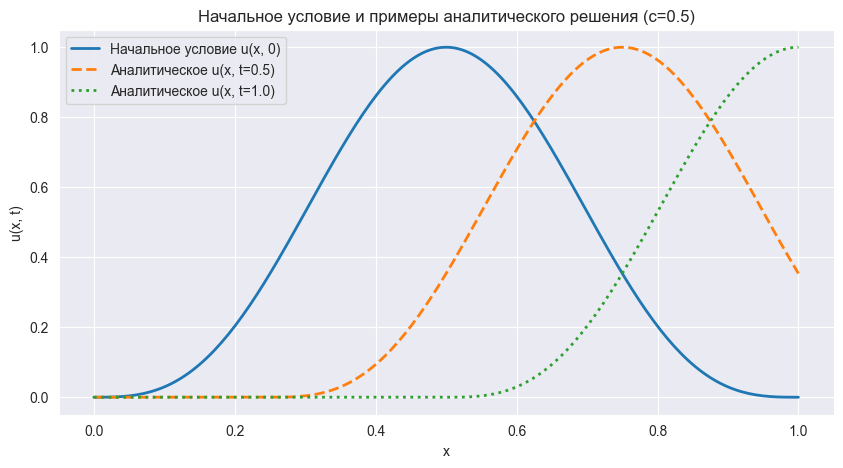

In [33]:
# --- Определяем параметры задачи и функции ---
X_MIN = 0.0
X_BORDER = 1.0
T_BORDER = 1.0
C_VAL = 0.5  # Положительная скорость -> движение вправо

def velocity(x, t):
    """Функция постоянной скорости."""
    return np.full_like(x, C_VAL) if isinstance(x, np.ndarray) else C_VAL

def source_term(x, t):
    """Нулевой источниковый член (однородное уравнение)."""
    return np.zeros_like(x) if isinstance(x, np.ndarray) else 0.0

def initial_condition(x):
    """Начальный волновой профиль."""
    return np.sin(np.pi * np.asarray(x))**3

def left_boundary_condition(t):
    """Левое граничное условие (Дирихле)."""
    return np.zeros_like(t) if isinstance(t, np.ndarray) else 0.0

def analytical_solution(x, t, c=C_VAL):
    """Аналитическое решение для однородного уравнения с данным НУ."""
    x = np.asarray(x)
    u = np.zeros_like(x, dtype=float)
    x_characteristic = x - c * t
    condition = (x >= c * t) & (x_characteristic >= X_MIN)
    u[condition] = initial_condition(x_characteristic[condition])
    return u

def right_boundary_condition(t, c=C_VAL, x_max=X_BORDER):
    """Правое граничное условие, использующее аналитическое решение."""
    return analytical_solution(x_max, t, c)

# --- График начального условия и примера аналитического решения ---
x_plot = np.linspace(X_MIN, X_BORDER, 200)
plt.figure(figsize=(10, 5))
plt.plot(x_plot, initial_condition(x_plot), label='Начальное условие u(x, 0)', lw=2)
plt.plot(x_plot, analytical_solution(x_plot, T_BORDER / 2), label=f'Аналитическое u(x, t={T_BORDER/2:.1f})', lw=2, linestyle='--')
plt.plot(x_plot, analytical_solution(x_plot, T_BORDER), label=f'Аналитическое u(x, t={T_BORDER:.1f})', lw=2, linestyle=':')
plt.title('Начальное условие и примеры аналитического решения (c=0.5)')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True)
plt.show()

"""
Эта функция создает пространственную и временную сетки, вычисляет шаги (h, tau),
инициализирует массив решения `u` и вычисляет число Куранта `r`.
"""

In [34]:
def init_grid_and_params(u_initial, x_min, x_max, t_max, Nx, Nt, c_func):
    """Инициализирует сетку, шаги по времени, массив решения и число Куранта."""
    h = (x_max - x_min) / (Nx - 1)  # Шаг по пространству
    tau = t_max / (Nt - 1)          # Шаг по времени

    x_grid = np.linspace(x_min, x_max, Nx)
    t_grid = np.linspace(0, t_max, Nt)

    u = np.zeros((Nt, Nx))
    u[0, :] = u_initial(x_grid)

    c_val = c_func(x_grid[Nx // 2], 0)
    r_val = c_val * tau / h if abs(h) > 1e-14 else float('inf')

    return h, tau, r_val, x_grid, t_grid, u, c_val

"""
Мы реализуем и сравним несколько распространенных конечно-разностных схем.
Используем обозначение: $u_n^j \approx u(x_n, t_j)$, где $x_n = x_{min} + n \cdot h$ и $t_j = j \cdot \tau$.
"""

# --- 3.1 FTCS (Явная по времени, центральная по пространству) ---
"""
Уравнение:
$$ \frac{u_n^{j+1} - u_n^j}{\tau} + c \frac{u_{n+1}^j - u_{n-1}^j}{2h} = 0 $$
В развернутом виде:
$$ u_n^{j+1} = u_n^j - \frac{r}{2} (u_{n+1}^j - u_{n-1}^j) $$
где $r = c \tau / h$.

Свойства:
- Явная.
- Порядок точности: $O(\tau, h^2)$.
- **Устойчивость:** Неустойчива.
"""

In [ ]:
def ftcs_scheme(c_func, f_func, u_initial, u_left_bc, u_right_bc,
                x_min, x_max, t_max, Nx, Nt):
    h, tau, r_val, x_grid, t_grid, u, c_val = init_grid_and_params(u_initial, x_min, x_max, t_max, Nx, Nt, c_func)
    f_on_grid = f_func(x_grid, 0)

    for j in range(Nt - 1):
        u[j + 1, 0] = u_left_bc(t_grid[j + 1])
        u[j + 1, -1] = u_right_bc(t_grid[j + 1])

        u_jp1_interior = u[j, 1:-1] - 0.5 * r_val * (u[j, 2:] - u[j, :-2]) + tau * f_on_grid[1:-1]

        u[j + 1, 1:-1] = u_jp1_interior

    ftcs_scheme.name = "FTCS (Неустойчивая)"
    return u, x_grid, t_grid

# --- 3.2 Левая схема "против потока" (Явная по времени, назад по пространству - FTBS) ---
"""
Уравнение (для c > 0):
$$ \frac{u_n^{j+1} - u_n^j}{\tau} + c \frac{u_n^j - u_{n-1}^j}{h} = 0 $$
В развернутом виде:
$$ u_n^{j+1} = u_n^j - r (u_n^j - u_{n-1}^j) $$

Свойства:
- Явная.
- Порядок точности: $O(\tau, h)$.
- **Устойчивость:** Условно устойчива для $c > 0$, если $0 \le r \le 1$.
- Вносит численную диффузию.
"""

In [36]:
def left_upwind_scheme(c_func, f_func, u_initial, u_left_bc, u_right_bc,
                       x_min, x_max, t_max, Nx, Nt):
    h, tau, r_val, x_grid, t_grid, u, c_val = init_grid_and_params(u_initial, x_min, x_max, t_max, Nx, Nt, c_func)
    f_on_grid = f_func(x_grid, 0)

    for j in range(Nt - 1):
        u[j + 1, 0] = u_left_bc(t_grid[j + 1])
        u[j + 1, 1:] = u[j, 1:] - r_val * (u[j, 1:] - u[j, :-1]) + tau * f_on_grid[1:]
        u[j + 1, -1] = u_right_bc(t_grid[j + 1])
    left_upwind_scheme.name = "Левая 'Против потока' (FTBS)"
    return u, x_grid, t_grid

# --- 3.3 Неявная схема 'Б' (Неявная по времени, назад по пространству - BTBS) ---
"""
Эта схема соответствует шаблону, показанному в исходном вопросе: (n-1, j+1), (n, j+1), (n, j).
Уравнение:
$$ \frac{u_n^{j+1} - u_n^j}{\tau} + c \frac{u_n^{j+1} - u_{n-1}^{j+1}}{h} = 0 $$
Преобразуем для решения относительно $u_n^{j+1}$:
$$ u_n^{j+1} = \frac{u_n^j + r u_{n-1}^{j+1}}{1 + r} $$

Свойства:
- Неявная.
- Порядок точности: $O(\tau, h)$.
- **Устойчивость:** Безусловно устойчива для $c > 0$.
- Вносит численную диффузию.
"""

In [37]:
def implicit_scheme_b(c_func, f_func, u_initial, u_left_bc, u_right_bc,
                      x_min, x_max, t_max, Nx, Nt):
    h, tau, r_val, x_grid, t_grid, u, c_val = init_grid_and_params(u_initial, x_min, x_max, t_max, Nx, Nt, c_func)
    denom = 1.0 + r_val

    for j in range(Nt - 1):
        t_next = t_grid[j+1]
        f_next_row = f_func(x_grid, t_next)
        u[j + 1, 0] = u_left_bc(t_next)

        for n in range(1, Nx):
            rhs = u[j, n] + tau * f_next_row[n]
            u[j + 1, n] = (rhs + r_val * u[j + 1, n - 1]) / denom

    implicit_scheme_b.name = "Неявная схема Б (BTBS)"
    return u, x_grid, t_grid

# --- 3.4 Схема Лакса-Фридрихса ---
"""
Уравнение:
$$ \frac{u_n^{j+1} - \frac{1}{2}(u_{n+1}^j + u_{n-1}^j)}{\tau} + c \frac{u_{n+1}^j - u_{n-1}^j}{2h} = 0 $$
В развернутом виде:
$$ u_n^{j+1} = \frac{1}{2}(u_{n+1}^j + u_{n-1}^j) - \frac{r}{2} (u_{n+1}^j - u_{n-1}^j) $$

Свойства:
- Явная.
- Порядок точности: $O(\tau, h^2)$ (часто ведет себя как первый порядок).
- **Устойчивость:** Условно устойчива, если $|r| \le 1$.
- Сильно диффузионная.
"""

In [38]:
def lax_friedrichs_scheme(c_func, f_func, u_initial, u_left_bc, u_right_bc,
                          x_min, x_max, t_max, Nx, Nt):
    h, tau, r_val, x_grid, t_grid, u, c_val = init_grid_and_params(u_initial, x_min, x_max, t_max, Nx, Nt, c_func)
    f_on_grid = f_func(x_grid, 0)

    for j in range(Nt - 1):
        u[j + 1, 0] = u_left_bc(t_grid[j + 1])
        u[j + 1, -1] = u_right_bc(t_grid[j + 1])

        u_jp1_interior = (0.5 * (u[j, 2:] + u[j, :-2])
                          - 0.5 * r_val * (u[j, 2:] - u[j, :-2]))
                          # + tau * f_on_grid[1:-1]

        u[j + 1, 1:-1] = u_jp1_interior

    lax_friedrichs_scheme.name = "Лакс-Фридрихс"
    return u, x_grid, t_grid

# --- 3.5 Схема Лакса-Вендроффа ---
"""
Уравнение:
$$ u_n^{j+1} = u_n^j - \frac{r}{2} (u_{n+1}^j - u_{n-1}^j) + \frac{r^2}{2} (u_{n+1}^j - 2u_n^j + u_{n-1}^j) $$

Свойства:
- Явная.
- Порядок точности: $O(\tau^2, h^2)$.
- **Устойчивость:** Условно устойчива, если $|r| \le 1$.
- Менее диффузионная, но может вносить осцилляции.
"""

In [39]:
def lax_wendroff_scheme(c_func, f_func, u_initial, u_left_bc, u_right_bc,
                        x_min, x_max, t_max, Nx, Nt):
    h, tau, r_val, x_grid, t_grid, u, c_val = init_grid_and_params(u_initial, x_min, x_max, t_max, Nx, Nt, c_func)
    f_on_grid = f_func(x_grid, 0)

    for j in range(Nt - 1):
        u[j + 1, 0] = u_left_bc(t_grid[j + 1])
        u[j + 1, -1] = u_right_bc(t_grid[j + 1])

        term1 = u[j, 1:-1]
        term2 = - 0.5 * r_val * (u[j, 2:] - u[j, :-2])
        term3 = + 0.5 * r_val**2 * (u[j, 2:] - 2*u[j, 1:-1] + u[j, :-2])
        term4 = tau * f_on_grid[1:-1]

        u_jp1_interior = term1 + term2 + term3 + term4
        u[j + 1, 1:-1] = u_jp1_interior

    lax_wendroff_scheme.name = "Лакс-Вендрофф"
    return u, x_grid, t_grid

"""
Теперь запустим каждую схему с выбранными параметрами (Nx, Nt) и визуализируем результаты.
Мы построим графики решения в разные моменты времени и тепловую карту, показывающую полную эволюцию.

Нам нужно выбрать Nx и Nt. Для явных схем Nt нужно выбирать осторожно, чтобы удовлетворить условию устойчивости, связанному с числом Куранта $r = c \tau / h$.
Зададим целевое число Куранта для устойчивых явных схем.
"""

Настройки моделирования: Nx=101, h=0.0100
Явные схемы (целевое r=0.2): Nt=251
  Фактическое tau=0.0040, Фактическое r=0.2000
Неявные схемы: Используется Nt=251 для сравнения.
  Фактическое tau=0.0040, Фактическое r (для справки)=0.2000

Запуск FTCS...
Моделирование FTCS завершено.

Запуск Левая 'Против потока'...
Моделирование Левая 'Против потока' завершено.

Запуск Неявная Б...
Моделирование Неявная Б завершено.

Запуск Лакс-Фридрихс...
Моделирование Лакс-Фридрихс завершено.

Запуск Лакс-Вендрофф...
Моделирование Лакс-Вендрофф завершено.
Построение графиков для FTCS (до t=1.000)


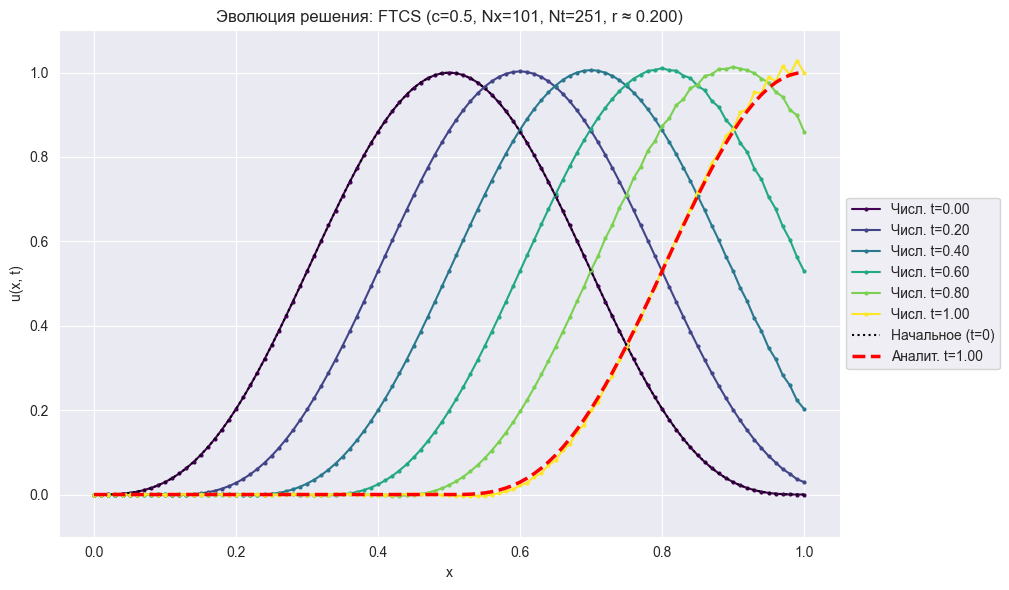

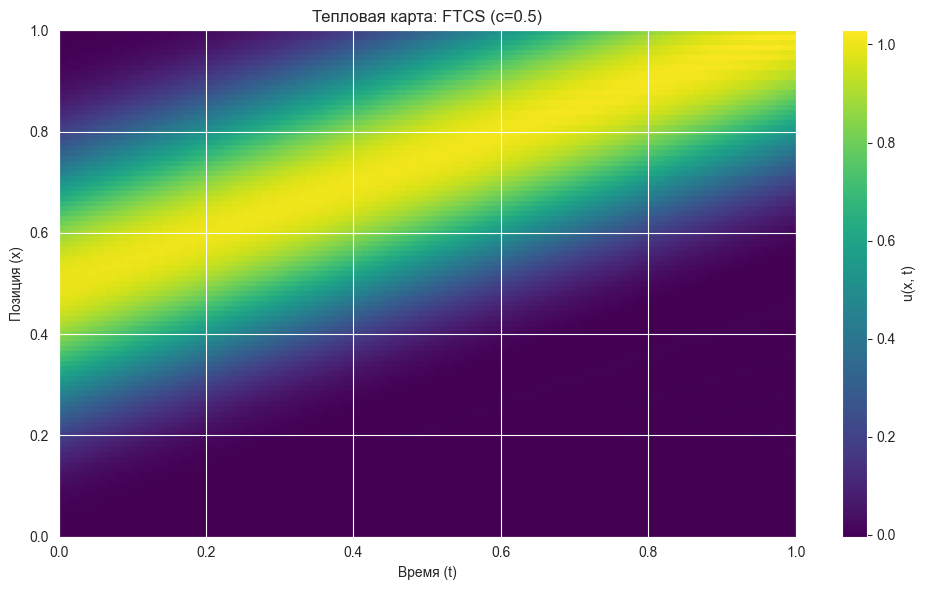

Построение графиков для Левая 'Против потока' (до t=1.000)


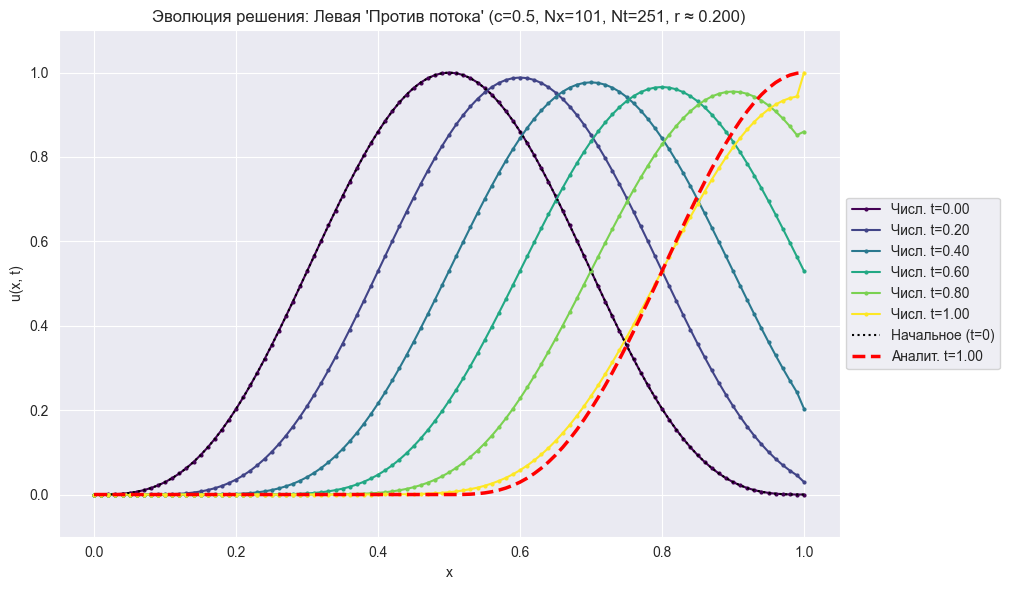

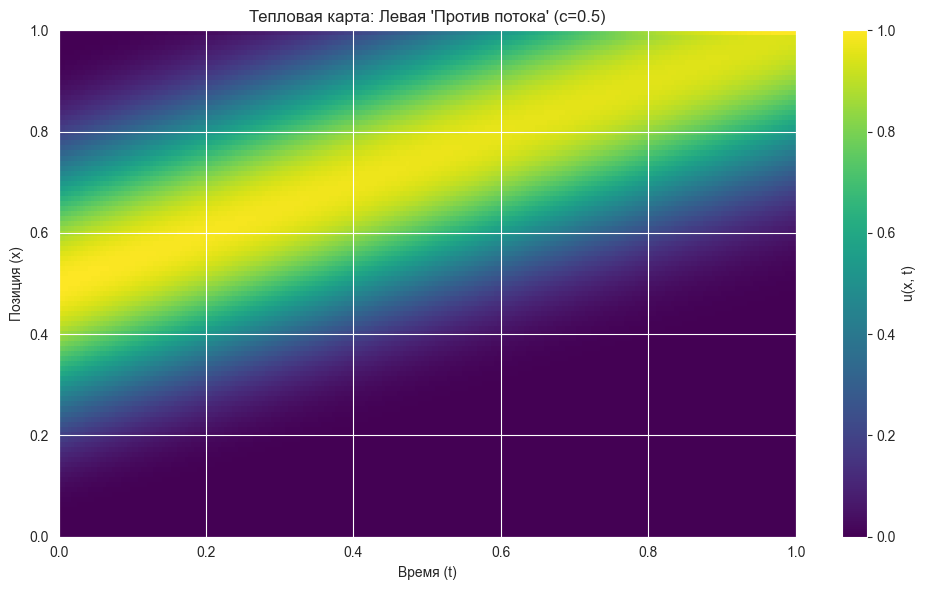

Построение графиков для Неявная Б (до t=1.000)


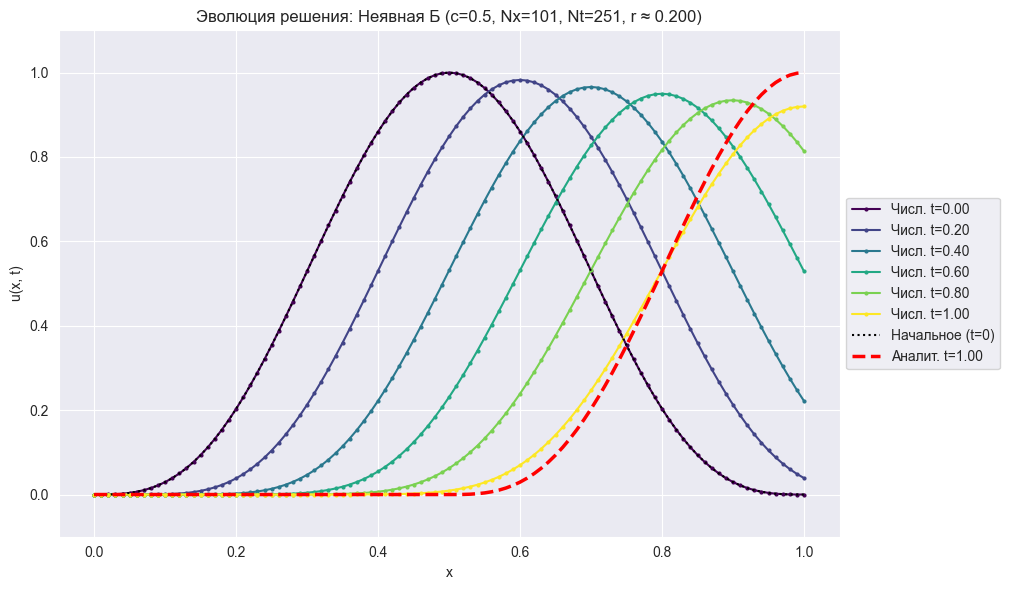

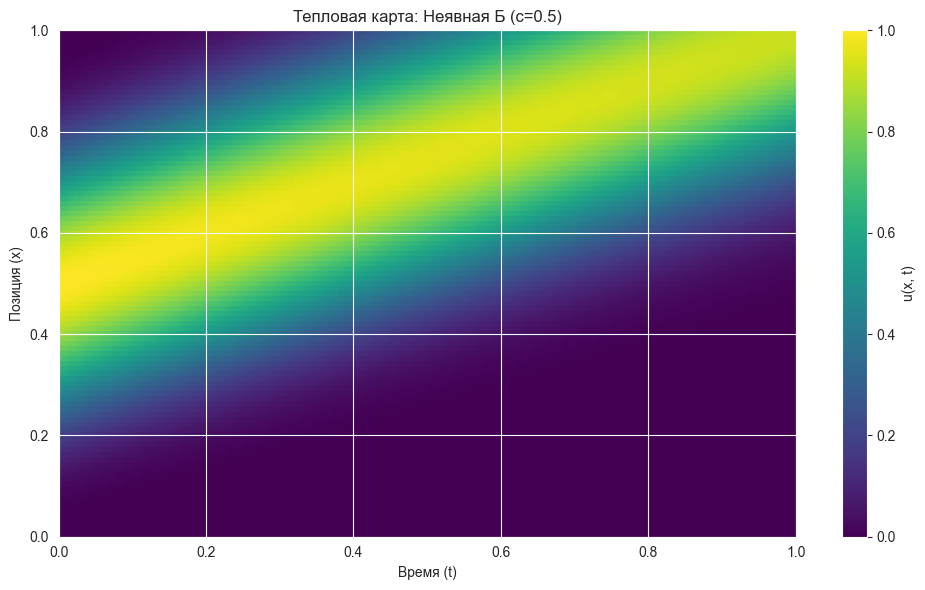

Построение графиков для Лакс-Фридрихс (до t=1.000)


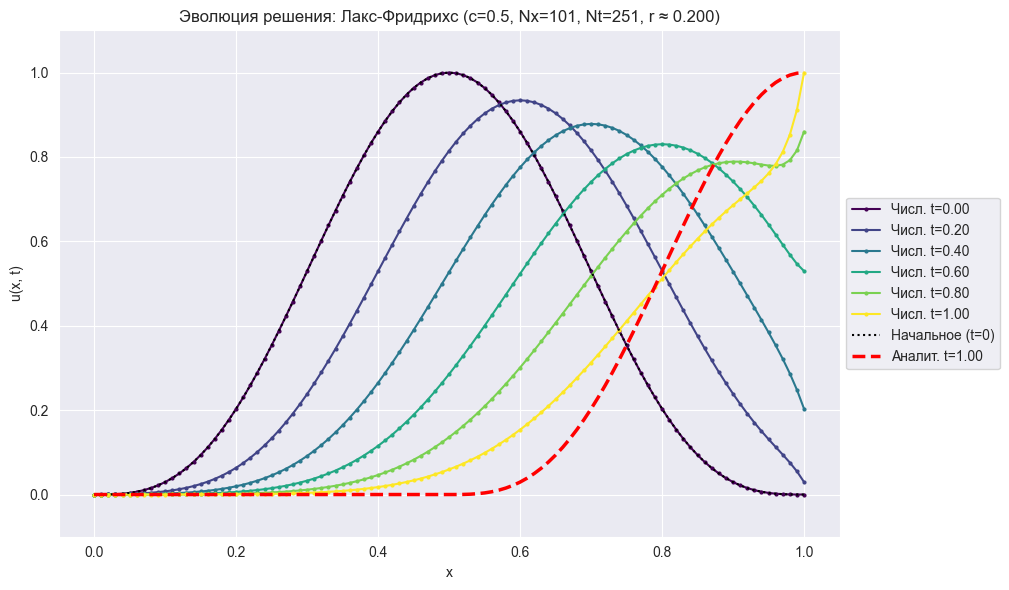

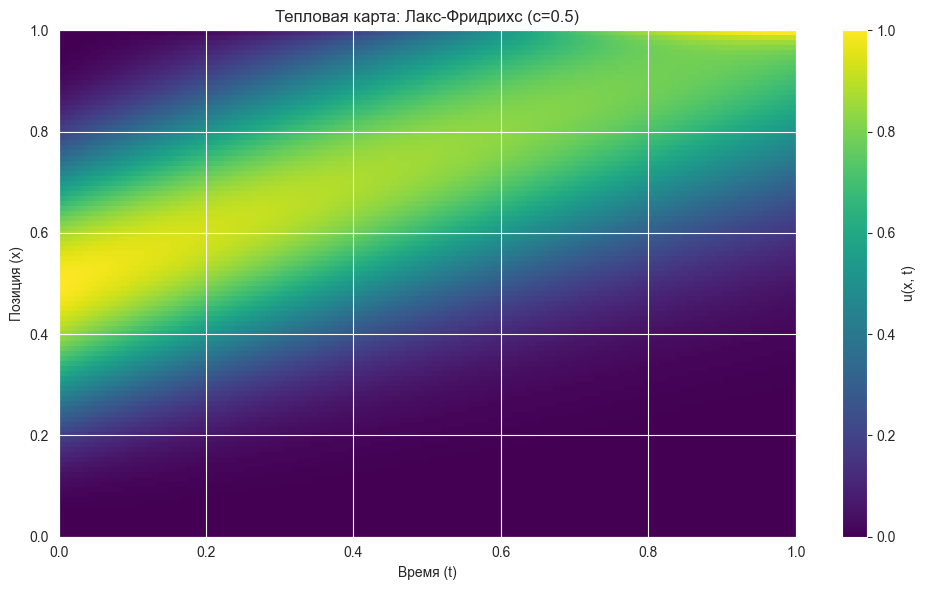

Построение графиков для Лакс-Вендрофф (до t=1.000)


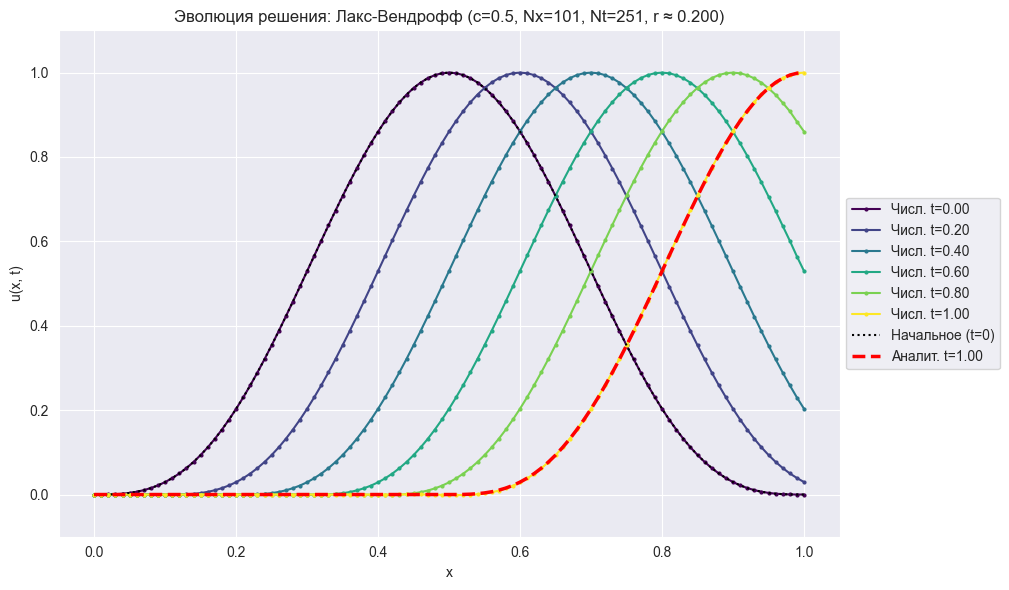

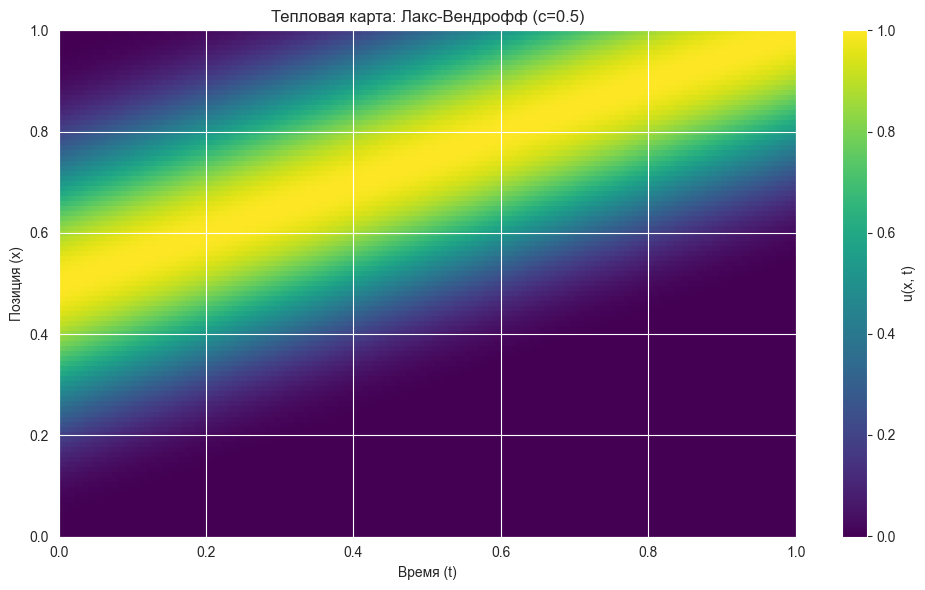

In [40]:
# --- Параметры Моделирования ---
Nx = 101
target_r = 0.2

h_sim = (X_BORDER - X_MIN) / (Nx - 1)
tau_explicit_target = target_r * h_sim / abs(C_VAL)
Nt_explicit = int(np.ceil(T_BORDER / tau_explicit_target)) + 1
if Nt_explicit < 2: Nt_explicit = 2

Nt_implicit = Nt_explicit

print(f"Настройки моделирования: Nx={Nx}, h={h_sim:.4f}")
print(f"Явные схемы (целевое r={target_r}): Nt={Nt_explicit}")
actual_tau_explicit = T_BORDER / (Nt_explicit - 1)
actual_r_explicit = C_VAL * actual_tau_explicit / h_sim
print(f"  Фактическое tau={actual_tau_explicit:.4f}, Фактическое r={actual_r_explicit:.4f}")
print(f"Неявные схемы: Используется Nt={Nt_implicit} для сравнения.")
actual_tau_implicit = T_BORDER / (Nt_implicit - 1)
actual_r_implicit = C_VAL * actual_tau_implicit / h_sim
print(f"  Фактическое tau={actual_tau_implicit:.4f}, Фактическое r (для справки)={actual_r_implicit:.4f}")

schemes_to_run = {
    "FTCS": (ftcs_scheme, Nt_explicit),
    "Левая 'Против потока'": (left_upwind_scheme, Nt_explicit),
    "Неявная Б": (implicit_scheme_b, Nt_implicit),
    "Лакс-Фридрихс": (lax_friedrichs_scheme, Nt_explicit),
    "Лакс-Вендрофф": (lax_wendroff_scheme, Nt_explicit),
}

simulation_results = {}

# --- Запуск Моделирования ---
for name, (func, nt_run) in schemes_to_run.items():
    print(f"\nЗапуск {name}...")
    # Предполагаем, что у функции есть атрибут name, присвоенный внутри
    simulation_results[name] = func(velocity, source_term, initial_condition,
                                    left_boundary_condition, right_boundary_condition,
                                    X_MIN, X_BORDER, T_BORDER, Nx, nt_run)
    print(f"Моделирование {name} завершено.")

# --- Функция Построения Графиков ---
def plot_solution_and_heatmap(name, result_tuple, analytical_sol_func, u_initial_func):
    """Строит временные срезы и тепловую карту для данного результата моделирования."""
    u_num, x_g, t_g = result_tuple

    # Упрощенная логика без проверки на NaN/ошибки симуляции
    last_valid_j = u_num.shape[0] - 1
    t_final = t_g[-1]
    u_ana_final = analytical_sol_func(x_g, t_final, c=C_VAL)
    r_actual_sim = C_VAL * (t_g[1]-t_g[0]) / (x_g[1]-x_g[0]) if len(t_g)>1 and len(x_g)>1 and abs(x_g[1]-x_g[0])>1e-14 else float('nan')

    print(f"Построение графиков для {name} (до t={t_final:.3f})")

    # График временных срезов
    plt.figure(figsize=(12, 6))
    num_slices = 6
    time_indices = np.linspace(0, last_valid_j, num_slices, dtype=int)
    colors = plt.cm.viridis(np.linspace(0, 1, num_slices))

    for i, idx in enumerate(time_indices):
        t_plot = t_g[idx]
        label = f'Числ. t={t_plot:.2f}'
        plt.plot(x_g, u_num[idx, :], color=colors[i], ls='-', marker='.', ms=4, lw=1.5, label=label)

    plt.plot(x_g, u_initial_func(x_g), 'k:', lw=1.5, label='Начальное (t=0)')
    plt.plot(x_g, u_ana_final, 'r--', lw=2.5, label=f'Аналит. t={t_final:.2f}')
    plt.xlabel("x")
    plt.ylabel("u(x, t)")
    plt.title(f"Эволюция решения: {name} (c={C_VAL}, Nx={len(x_g)}, Nt={len(t_g)}, r ≈ {r_actual_sim:.3f})")
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    min_val = min(u_initial_func(x_g).min(), u_ana_final.min())
    max_val = max(u_initial_func(x_g).max(), u_ana_final.max())
    plt.ylim(min_val - 0.1*(max_val-min_val+1e-6), max_val + 0.1*(max_val-min_val+1e-6))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

    # Тепловая карта
    plt.figure(figsize=(10, 6))
    im = plt.imshow(u_num[:last_valid_j+1, :].T,
                    extent=[t_g[0], t_final, x_g[0], x_g[-1]],
                    origin='lower', aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(im, label='u(x, t)')
    plt.xlabel("Время (t)")
    plt.ylabel("Позиция (x)")
    plt.title(f"Тепловая карта: {name} (c={C_VAL})")
    plt.tight_layout()
    plt.show()

# --- Генерация Графиков ---
for name, result_data in simulation_results.items():
    plot_solution_and_heatmap(name, result_data, analytical_solution, initial_condition)

"""
Мы исследуем, как ошибка каждой численной схемы уменьшается при уменьшении шагов (h, tau).
Ожидается, что ошибка $E = ||u_{numerical} - u_{analytical}||$ ведет себя как $E \approx C \cdot h^p$, где $p$ - порядок сходимости по пространству. Чтобы поддерживать устойчивость или согласованную точность для разных схем, мы часто сохраняем число Куранта $r = c \tau / h$ постоянным. Это подразумевает $\tau \propto h$, поэтому ошибка может также зависеть от порядка по $\tau$.

Мы измеряем ошибку, используя максимальную норму (L-бесконечность) в конечный момент времени T:
$$ E_{max} = \max_{n} |u_n^N - u_{analytical}(x_n, T)| $$
где N - индекс конечного временного шага, соответствующего $T = t_N$.

Строя график $\log(E_{max})$ против $\log(h)$, мы ожидаем прямую линию с наклоном $p$.

Мы будем использовать фиксированное число Куранта $r_{stable}$ для анализа, подходящее для устойчивых явных схем. Неявные схемы также будут запускаться с соответствующим $\tau$ для сравнения, хотя они могут быть устойчивы и для больших $\tau$.
"""


Начало анализа сходимости

--- Анализ сходимости для FTCS (Неустойчивая) (Целевое r=0.04) ---
Тестируемые значения Nx: [ 31  62 123 247 495 992]


Оцененный порядок сходимости (Макс. норма): 1.115 ± 0.072


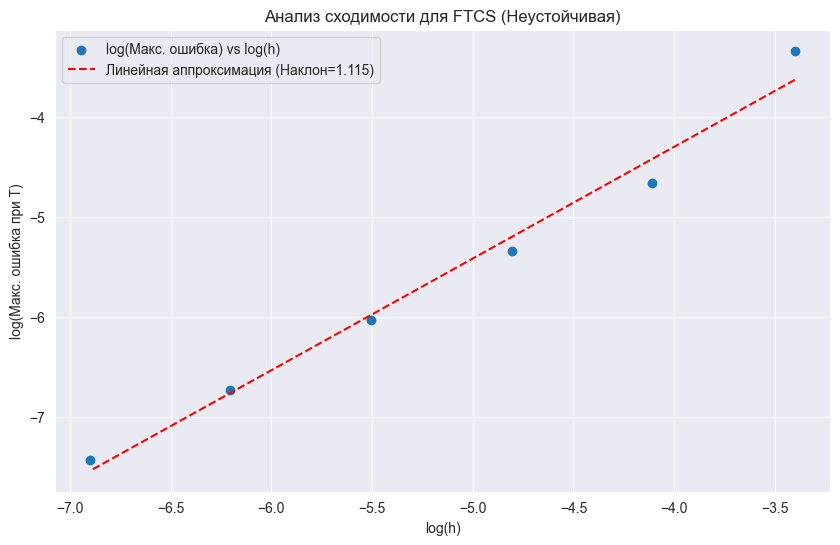


--- Анализ сходимости для Левая 'Против потока' (FTBS) (Целевое r=0.04) ---
Тестируемые значения Nx: [ 31  62 123 247 495 992]


Оцененный порядок сходимости (Макс. норма): 0.922 ± 0.019


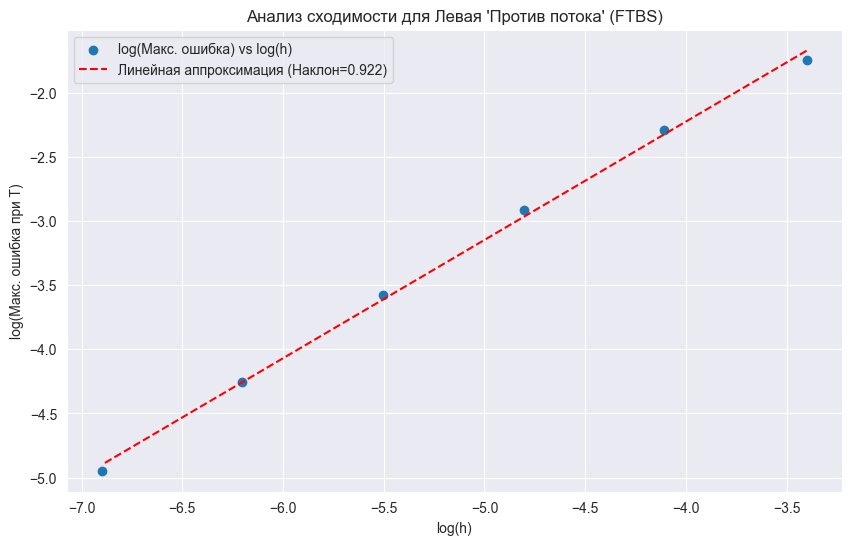


--- Анализ сходимости для Неявная схема Б (BTBS) (Целевое r=0.04) ---
Тестируемые значения Nx: [ 31  62 123 247 495 992]


Оцененный порядок сходимости (Макс. норма): 0.929 ± 0.016


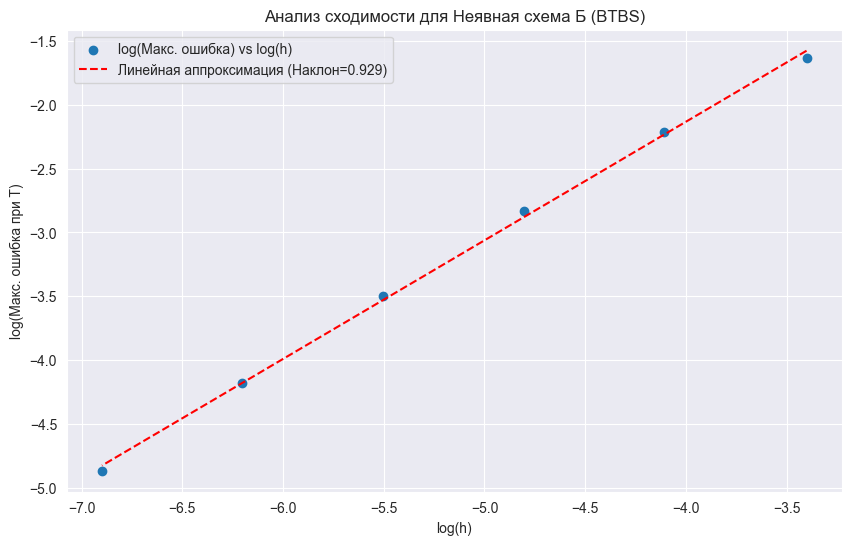


--- Анализ сходимости для Лакс-Фридрихс (Целевое r=0.5) ---
Тестируемые значения Nx: [ 31  62 123 247 495 992]


Оцененный порядок сходимости (Макс. норма): 0.848 ± 0.035


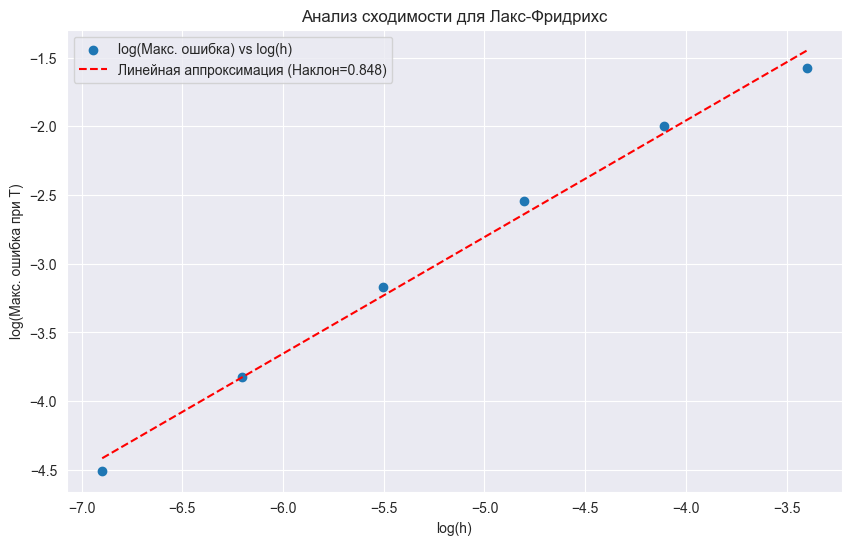


--- Анализ сходимости для Лакс-Вендрофф (Целевое r=0.04) ---
Тестируемые значения Nx: [ 31  62 123 247 495 992]


Оцененный порядок сходимости (Макс. норма): 2.108 ± 0.018


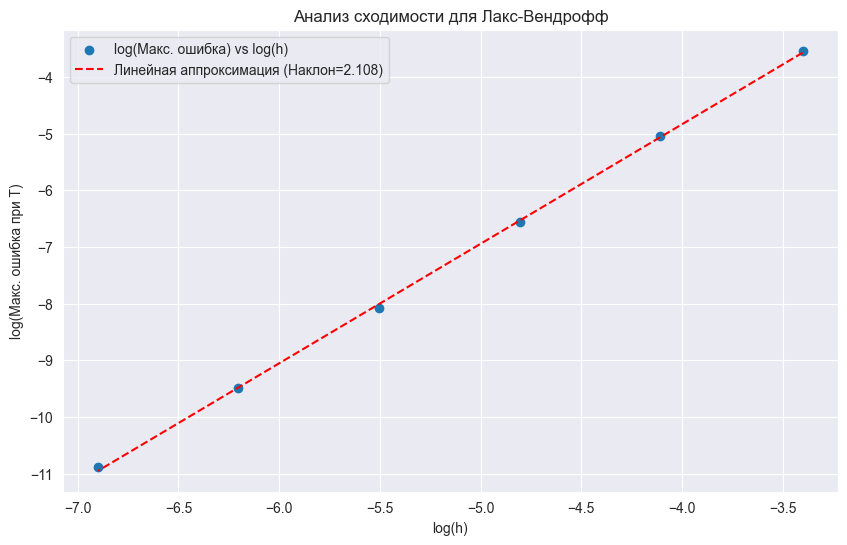


Резюме сходимости
FTCS: Оцененный порядок ≈ 1.115 (Теоретический: Неустойчива)
Левая 'Против потока': Оцененный порядок ≈ 0.922 (Теоретический: 1)
Неявная Б: Оцененный порядок ≈ 0.929 (Теоретический: 1)
Лакс-Фридрихс: Оцененный порядок ≈ 0.848 (Теоретический: 1)
Лакс-Вендрофф: Оцененный порядок ≈ 2.108 (Теоретический: 2)


In [44]:
# --- Вспомогательная функция для сходимости ---
def linear_regr(log_h, slope, intercept):
    """Линейная функция для аппроксимации кривой: log(Ошибка) = наклон * log(h) + пересечение."""
    return slope * log_h + intercept

def calculate_convergence(scheme_func, analytical_sol, c_func, f_func,
                          u_initial, u_left_bc, u_right_bc,
                          x_min, x_max, t_max, N_steps=6, Nx_base=21,
                          r_stable=0.2, c_const=C_VAL):
    """Вычисляет и строит график сходимости для данной схемы."""

    if not hasattr(scheme_func, 'name'):
        scheme_func.name = scheme_func.__name__.replace("_", " ").title()
    print(f"\n--- Анализ сходимости для {scheme_func.name} (Целевое r={r_stable}) ---")

    errors_max = []
    h_values = []

    Nx_values = np.unique(np.geomspace(Nx_base, Nx_base * 2**(N_steps-1), N_steps, dtype=int))
    Nx_values = Nx_values[Nx_values <= 4001]
    print(f"Тестируемые значения Nx: {Nx_values}")

    # Используем обычный tqdm здесь тоже
    for Nx_test in tqdm(Nx_values, desc=f"Сходимость {scheme_func.name}", leave=False):
        h = (x_max - x_min) / (Nx_test - 1)

        tau_target = r_stable * h / abs(c_const)
        Nt_test = int(np.round(t_max / tau_target)) + 1
        if Nt_test < 3: Nt_test = 3

        actual_tau = t_max / (Nt_test - 1)
        actual_r = abs(c_const * actual_tau / h) if abs(h) > 1e-14 else float('inf')

        # Запускаем симуляцию, предполагая, что она завершится успешно
        solution_num, x_grid, t_grid = scheme_func(
            c_func, f_func, u_initial, u_left_bc, u_right_bc,
            x_min, x_max, t_max, Nx_test, Nt_test
        )

        u_analytical_final = analytical_sol(x_grid, t_grid[-1], c=c_const)
        max_error = np.max(np.abs(solution_num[-1, :] - u_analytical_final))

        # Сохраняем результаты без проверки на валидность ошибки
        errors_max.append(max_error)
        h_values.append(h)

    # --- Аппроксимация и построение графика (без проверок на достаточность данных) ---
    # Проверяем, есть ли вообще данные для логарифмирования
    if not h_values or not errors_max:
        print("Нет данных для анализа сходимости.")
        return None
        
    # Попытка взять логарифм, игнорируя ошибки для нулевых или отрицательных значений
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        log_h = np.log(np.array(h_values))
        log_error = np.log(np.array(errors_max))

    valid_indices = np.isfinite(log_h) & np.isfinite(log_error)
    log_h_valid = log_h[valid_indices]
    log_error_valid = log_error[valid_indices]
    
    # Проверяем, достаточно ли точек после фильтрации
    if len(log_h_valid) < 2: # Нужно хотя бы 2 точки для линии
        print("Недостаточно валидных точек для линейной аппроксимации.")
        return None

    estimated_order = None
    try:
        # Аппроксимируем, предполагая, что это возможно
        popt, pcov = curve_fit(linear_regr, log_h_valid, log_error_valid)
        estimated_order = popt[0]
        perr = np.sqrt(np.diag(pcov))
        slope_std_err = perr[0]
        print(f"Оцененный порядок сходимости (Макс. норма): {estimated_order:.3f} ± {slope_std_err:.3f}")

        # Построение графика
        plt.figure(figsize=(10, 6))
        plt.scatter(log_h_valid, log_error_valid, marker='o', label=f'log(Макс. ошибка) vs log(h)')
        plt.plot(log_h_valid, linear_regr(log_h_valid, *popt), color='red', linestyle='--', label=f'Линейная аппроксимация (Наклон={estimated_order:.3f})')
        plt.xlabel("log(h)")
        plt.ylabel("log(Макс. ошибка при T)")
        plt.title(f"Анализ сходимости для {scheme_func.name}")
        plt.grid(True)
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Ошибка во время аппроксимации или построения графика: {e}")
        # Попытка построить точки, если они есть
        if len(log_h_valid) > 0:
            plt.figure(figsize=(10, 6))
            plt.scatter(log_h_valid, log_error_valid, marker='o', label=f'log(Макс. ошибка) vs log(h)')
            plt.xlabel("log(h)")
            plt.ylabel("log(Макс. ошибка при T)")
            plt.title(f"Данные сходимости для {scheme_func.name} (Аппроксимация не удалась)")
            plt.grid(True)
            plt.legend()
            plt.show()
            
    return estimated_order


# --- Запускаем анализ сходимости для каждой схемы (включая FTCS) ---
print("\n" + "="*40 + "\nНачало анализа сходимости\n" + "="*40)
convergence_results = {}

r_conv_analysis = 0.05

for name, (func, _) in schemes_to_run.items():
     scheme_function = func
     if(name == 'Лакс-Фридрихс'):
         r_conv_analysis = 0.5
     else:
         r_conv_analysis = 0.04 
     convergence_results[name] = calculate_convergence(
                                    scheme_function, analytical_solution, velocity, source_term,
                                    initial_condition, left_boundary_condition, right_boundary_condition,
                                    X_MIN, X_BORDER, T_BORDER, N_steps=6, Nx_base=31,
                                    r_stable=r_conv_analysis, c_const=C_VAL)
     
# --- Резюме результатов сходимости ---
print("\n" + "="*40 + "\nРезюме сходимости\n" + "="*40)
theoretical_orders = {
    "FTCS": "Неустойчива",
    "Левая 'Против потока'": 1,
    "Неявная Б": 1,
    "Лакс-Фридрихс": 1,
    "Лакс-Вендрофф": 2
}

for name, order in convergence_results.items():
    base_name_parts = name.split(" (")
    theo_order = theoretical_orders.get(base_name_parts[0], "Н/Д")
    if order is not None:
        print(f"{name}: Оцененный порядок ≈ {order:.3f} (Теоретический: {theo_order})")
    else:
        # Вывод для схем, где анализ мог не удасться
        print(f"{name}: Анализ сходимости не дал числового результата или не удался (Теоретический: {theo_order}).")
